Notebook outlining what functions from nltk will be useful for pre-processing the text and training the classification algorithm.

Expects a CSV file in the current directory containing a release's date, text, and classification (pos or neg) in each row.

In [196]:
import math
import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

from sklearn import decomposition, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Some pre-processing to get the dataframe into the format we need for content analysis.

In [3]:
release_df = pd.read_csv('release_df.csv', index_col=0)

In [4]:
release_df.tail()

,date,release_text,year,month
80,"August 05, 2008",The Federal Open Market Committee decided toda...,2008,August
81,"September 16, 2008",The Federal Open Market Committee decided toda...,2008,September
82,"October 08, 2008",Joint Statement by Central Banks\nThroughout t...,2008,October
83,"October 29, 2008",The Federal Open Market Committee decided toda...,2008,October
84,"December 16, 2008",The Federal Open Market Committee decided toda...,2008,December


- Need to add historical text data. DONE
- Need to add historical rate data. DONE
- Need to merge two datasets. DONE

`allratesdf.csv` contains cleaned DataFrame of all relevant rate changes from 1960.

In [33]:
allratesdf = pd.read_csv('allratesdf.csv', index_col=0)

In [63]:
allratesdf.head()

,month,year,Change,increase
0,February,1994,0.07,True
1,March,1994,0.03,True
2,April,1994,0.07,True
3,May,1994,0.13,True
4,June,1994,0.06,True


`ratesfrom06` is a cleaned DataFrame with rates from 2006 on, which is our set for analysis.

In [39]:
ratesfrom06 = allratesdf.iloc[143:]

In [41]:
ratesfrom06.reset_index(inplace=True, drop=True)

In [43]:
ratesfrom06.head()

,month,year,Change,increase
0,January,2006,0.03,True
1,February,2006,0.05,True
2,March,2006,0.02,True
3,April,2006,0.04,True
4,May,2006,0.03,True


Now, to merge the text and rates DataFrames and clean the result. `releaserates_df` has all rate changes since 2006 and their associated release text.

In [76]:
#releaserates_df = ratesfrom06.merge(release_df, how='left', on=['year', 'month'])
#releaserates_df = releaseratesdf.ffill()
releaserates_df = pd.read_csv('releaserates_df.csv', index_col=0)

In [78]:
releaserates_df.head()

,month,year,Change,increase,date,release_text
0,January,2006,0.03,True,"January 31, 2006",The Federal Open Market Committee decided toda...
1,February,2006,0.05,True,"January 31, 2006",The Federal Open Market Committee decided toda...
2,March,2006,0.02,True,"March 28, 2006",The Federal Open Market Committee decided toda...
3,April,2006,0.04,True,"March 28, 2006",The Federal Open Market Committee decided toda...
4,May,2006,0.03,True,"May 10, 2006",The Federal Open Market Committee decided toda...


Now text processing using `nltk`.

In [5]:
releaserates_df = pd.read_csv('releaserates_df.csv', index_col=0)

In [6]:
releaserates_df.head()

,month,year,Change,increase,date,release_text
0,January,2006,0.03,True,"January 31, 2006",The Federal Open Market Committee decided toda...
1,February,2006,0.05,True,"January 31, 2006",The Federal Open Market Committee decided toda...
2,March,2006,0.02,True,"March 28, 2006",The Federal Open Market Committee decided toda...
3,April,2006,0.04,True,"March 28, 2006",The Federal Open Market Committee decided toda...
4,May,2006,0.03,True,"May 10, 2006",The Federal Open Market Committee decided toda...


### LOGISTIC REGRESSION

First, we try a Logistic Regression using PCA on tf-idf vectors.

In [85]:
x_train, x_test, y_train, y_test = train_test_split(releaserates_df['release_text'], releaserates_df['increase'], test_size = .40, random_state = 42)

In [86]:
releaseTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')

In [87]:
releaseTFVects = releaseTFVectorizer.fit_transform(x_train)

If interested in the scores assigned to words:

In [88]:
#sorted(list(zip(releaseTFVectorizer.vocabulary_.keys(), releaseTFVects.data)), key=lambda x: x[1], reverse=True)

In [89]:
PCA = decomposition.PCA
pca = PCA().fit(releaseTFVects.toarray())
reduced_data = pca.transform(releaseTFVects.toarray())

A Scree Plot indicating the proportion of variance explained by the first $x$ principal components.

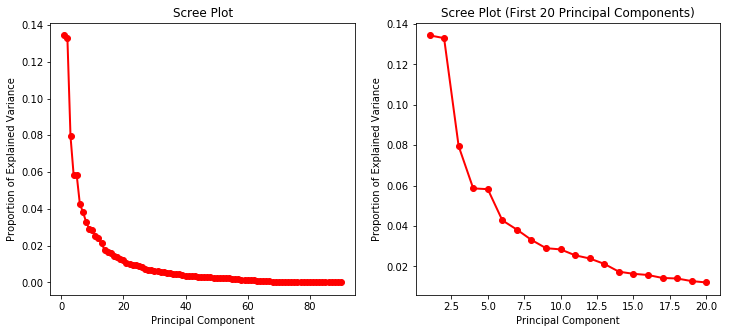

In [90]:
n = releaseTFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

We'll first try a Logistic Regression using the first 10 principal components as regressors.

In [91]:
X = reduced_data[:, :10]
Y = np.array([int(label) for label in y_train])

In [92]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [93]:
print('For training set: {}'.format(logistic.score(X,Y)))

For training set: 0.7444444444444445


In [94]:
releaseTFVects_test = releaseTFVectorizer.transform(x_test)
reduced_data_test = pca.transform(releaseTFVects_test.toarray())
X_test = reduced_data_test[:, :10]
Y_test = np.array([int(label) for label in y_test])
print('For testing set: {}'.format(logistic.score(X_test, Y_test)))

For testing set: 0.6


Not so good...

How about 21 principal components? (Seems like a reasonable knee in the scree plot)

In [95]:
X = reduced_data[:, :21]
Y = np.array([int(label) for label in y_train])

In [96]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)
print('For training set: {}'.format(logistic.score(X,Y)))

For training set: 0.8111111111111111


In [97]:
releaseTFVects_test = releaseTFVectorizer.transform(x_test)
reduced_data_test = pca.transform(releaseTFVects_test.toarray())
X_test = reduced_data_test[:, :21]
Y_test = np.array([int(label) for label in y_test])
print('For testing set: {}'.format(logistic.score(X_test, Y_test)))

For testing set: 0.6166666666666667


After this point, more components doesn't result in much of an increase in predictive power. But, this still isn't great. To solve this problem, we should try different classifying algorithms.

### NAIVE BAYES

In [246]:
releaserates_df.iloc[125:]

,month,year,Change,increase,date,release_text
125,January,2016,0.42,True,"January 27, 2016",Information received since the Federal Open Ma...
126,February,2016,0.12,True,"January 27, 2016",Information received since the Federal Open Ma...
127,March,2016,-0.05,False,"March 16, 2016",Information received since the Federal Open Ma...
128,April,2016,0.03,True,"April 27, 2016",Information received since the Federal Open Ma...
129,May,2016,0.00,False,"April 27, 2016",Information received since the Federal Open Ma...
130,June,2016,0.03,True,"June 15, 2016",Information received since the Federal Open Ma...
131,July,2016,0.03,True,"July 27, 2016",Information received since the Federal Open Ma...
132,August,2016,0.03,True,"July 27, 2016",Information received since the Federal Open Ma...
133,September,2016,0.00,False,"September 21, 2016",Information received since the Federal Open Ma...
134,October,2016,0.00,False,"September 21, 2016",Information received since the Federal Open Ma...


In [247]:
#x_train, x_test, y_train, y_test = train_test_split(releaserates_df['release_text'], releaserates_df['increase'], test_size = .41, random_state = 42)
#train_df = pd.DataFrame({'release_text':x_train, 'increase':y_train})
#test_df = pd.DataFrame({'release_text':x_test, 'increase' : y_test})

# settings for testing on releases after Jan 2017
#train_df = releaserates_df.iloc[:137].copy()
#test_df = releaserates_df.iloc[137:].copy()

# settings for testing on releases after Jan 2016
train_df = releaserates_df.iloc[:125].copy()
test_df = releaserates_df.iloc[125:].copy()

In [249]:
clf = sklearn.naive_bayes.GaussianNB()
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=15, stop_words='english', norm='l2')

TFVects = TFVectorizer.fit_transform(train_df['release_text'])
train_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

TFVects_test = TFVectorizer.transform(test_df['release_text'])
test_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [250]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_df['vect'], axis=0), train_df['increase'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [251]:
print("Training:")
print(naiveBayes.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print("Testing:")
print(naiveBayes.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training:
0.864
Testing:
0.24


### DECISION TREE

In [252]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_df['vect'], axis =0), train_df['increase'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [253]:
print("Training:")
print(sklearn.metrics.accuracy_score(train_df['increase'],clf_tree.predict(np.stack(train_df['vect'], axis = 0))))
print("Testing:")
print(sklearn.metrics.accuracy_score(test_df['increase'],clf_tree.predict(np.stack(test_df['vect'], axis = 0))))

Training:
0.768
Testing:
0.72


### BAGGING

In [254]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [255]:
bag.fit(np.stack(train_df['vect'], axis =0), train_df['increase']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [256]:
print("Training:")
print(bag.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print("Testing:")
print(bag.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training:
0.928
Testing:
0.2


### KNN

In [257]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [258]:
clf_knearest.fit(np.stack(train_df['vect'], axis = 0), train_df['increase'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [259]:
print('Training: ')
print(clf_knearest.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print('Testing: ')
print(clf_knearest.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training: 
0.704
Testing: 
0.24


### SVM

#### Linear

In [260]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
clf_svm.fit(np.stack(train_df['vect'], axis=0), train_df['increase'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [261]:
print('Training: ')
print(clf_svm.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print('Testing: ')
print(clf_svm.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training: 
0.88
Testing: 
0.76


#### Cubic

In [262]:
clf_svm = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = False)
clf_svm.fit(np.stack(train_df['vect'], axis=0), train_df['increase'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [263]:
print('Training: ')
print(clf_svm.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print('Testing: ')
print(clf_svm.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training: 
0.544
Testing: 
0.24


### NEURAL NETS

In [264]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_df['vect'], axis=0), train_df['increase'])

/Users/jgdenby/Library/Python/3.6/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [265]:
print('Training: ')
print(clf_nn.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print('Testing: ')
print(clf_nn.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training: 
0.936
Testing: 
0.76
